# Cassava Leaf Disease Classification - EDA

- toc: true
- badges: true
- categories: [plant,disease,classification,eda]


In this competition, we are trying to identify common diseases of cassava crops using data science and machine learning. Previous methods of disease detection require farmers to solicit the help of government-funded agricultural experts to visually inspect and diagnose the plants. This suffers from being labor-intensive, low-supply and costly. Instead, it would be preferred if an automated pipeline based on mobile-quality photos of the cassava leafs could be developed.

This competition provides a farmer-crowdsourced dataset, labeled by experts at the National Crops Resources Research Institute (NaCRRI).

In this kernel, I will present a quick EDA.

In [81]:
#collapse-hide
import numpy as np
import pandas as pd
import seaborn as sns
import albumentations as A
import matplotlib.pyplot as plt
from pathlib import Path
Path.ls = lambda x : list(x.iterdir())
import os, gc, cv2, random, warnings, math, sys, json, pprint, pdb

import tensorflow as tf
from tensorflow.keras import backend as K

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
warnings.simplefilter('ignore')

In [79]:
#collapse-hide
# helper function to plot sample 
def plot_imgs(dataset_show, iters):
    rcParams['figure.figsize'] = 20,10
    for i in range(iters):
        f, ax = plt.subplots(1,5)
        for p in range(5):
            idx = np.random.randint(0, len(dataset_show))
            img, label = dataset_show[idx]
            ax[p].grid(False)
            ax[p].imshow(img[0])
            ax[p].set_title(idx)
    plt.show()
    

def visualize(path, n_images, is_random=True, figsize=(16, 16)):
    plt.figure(figsize=figsize)
    
    w = int(n_images ** .5)
    h = math.ceil(n_images / w)
    
    image_names = path.ls()
    for i in range(n_images):
        image_name = random.choice(image_names) if is_random else image_name[i];
        img = cv2.imread(str(image_name))
        plt.subplot(h, w, i + 1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.show()  

In [7]:
#hide
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [8]:
dataset_path = Path('/content/gdrive/MyDrive/1_AUSTIN CHEN/Data Scientist/Datasets/cassava-leaf-disease-classification')
dataset_path.ls()

[PosixPath('/content/gdrive/MyDrive/1_AUSTIN CHEN/Data Scientist/Datasets/cassava-leaf-disease-classification/label_num_to_disease_map.json'),
 PosixPath('/content/gdrive/MyDrive/1_AUSTIN CHEN/Data Scientist/Datasets/cassava-leaf-disease-classification/sample_submission.csv'),
 PosixPath('/content/gdrive/MyDrive/1_AUSTIN CHEN/Data Scientist/Datasets/cassava-leaf-disease-classification/train.csv'),
 PosixPath('/content/gdrive/MyDrive/1_AUSTIN CHEN/Data Scientist/Datasets/cassava-leaf-disease-classification/cassava-leaf-disease-classification.zip'),
 PosixPath('/content/gdrive/MyDrive/1_AUSTIN CHEN/Data Scientist/Datasets/cassava-leaf-disease-classification/test_images'),
 PosixPath('/content/gdrive/MyDrive/1_AUSTIN CHEN/Data Scientist/Datasets/cassava-leaf-disease-classification/test_tfrecords'),
 PosixPath('/content/gdrive/MyDrive/1_AUSTIN CHEN/Data Scientist/Datasets/cassava-leaf-disease-classification/train_images'),
 PosixPath('/content/gdrive/MyDrive/1_AUSTIN CHEN/Data Scientist/Da

In [11]:
train_df = pd.read_csv(dataset_path/'train.csv')

In [15]:
train_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [35]:
train_df['path'] = train_df['image_id'].map(lambda x : dataset_path/'train_images'/x)
train_df = train_df.drop(columns = ['image_id'])
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [36]:
train_df.head()

,label,path
0,3,/content/gdrive/MyDrive/1_AUSTIN CHEN/Data Sci...
1,3,/content/gdrive/MyDrive/1_AUSTIN CHEN/Data Sci...
2,0,/content/gdrive/MyDrive/1_AUSTIN CHEN/Data Sci...
3,2,/content/gdrive/MyDrive/1_AUSTIN CHEN/Data Sci...
4,3,/content/gdrive/MyDrive/1_AUSTIN CHEN/Data Sci...


Check how many images are available in the training dataset and also check if each item in the training set are unique

In [20]:
print(f"There are {len(train_df)} train images")
len(train_df.image_id) == len(train_df.image_id.unique())

There are 21397 train images


True

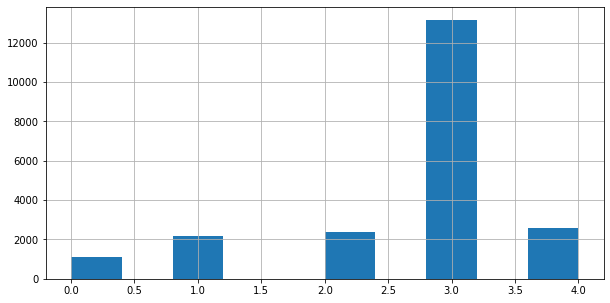

In [21]:
train_df['label'].hist(figsize = (10, 5))

In [30]:
with open(dataset_path/'label_num_to_disease_map.json') as file:
  id2label = json.loads(file.read())
id2label

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

In this case, we have 5 labels (4 diseases and healthy):

1. Cassava Bacterial Blight (CBB)
2. Cassava Brown Streak Disease (CBSD)
3. Cassava Green Mottle (CGM)
4. Cassava Mosaic Disease (CMD)
5. Healthy

In this case label 3, [Cassava Mosaic Disease (CMD)](https://en.wikipedia.org/wiki/Cassava_mosaic_virus) is the most common label. This imbalance may have to be addressed with a weighted loss function or oversampling. I might try this in a future iteration of this kernel or in a new kernel.

Let's check an example image to see what it looks like

In [88]:
from PIL import Image
im = Image.open(train_df[train_df.label==3]['path'][0])

In [89]:
width, height = im.size
print(width, height)

800 600


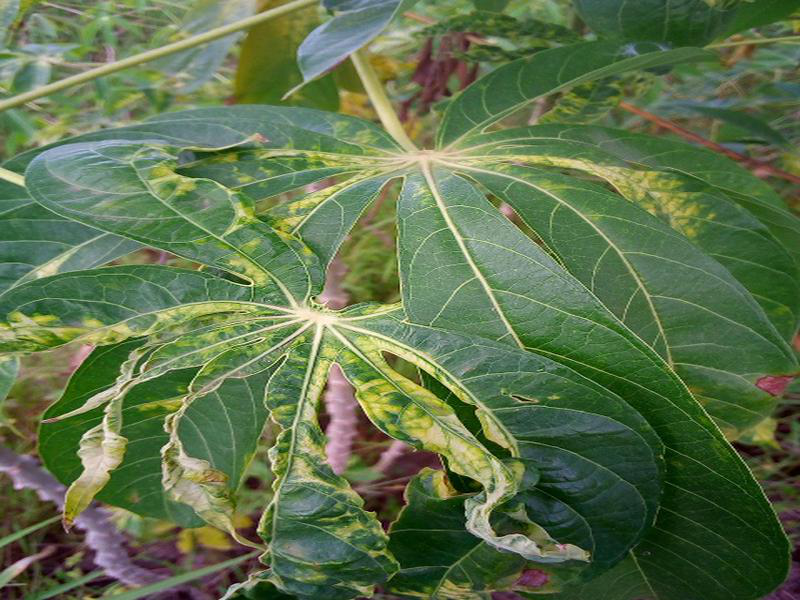

In [101]:
im

# Data loading

After my quick and rough EDA, let's load the PIL Image to a Numpy array, so we can move on to data augmentation.

In fastai, they have `item_tfms` and `batch_tfms` defined for their data loader API. The item transforms performs a fairly large crop to 224 and also apply other standard augmentations (in aug_tranforms) at the batch level on the GPU. The batch size is set to 32 here.


In [ ]:
#item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
#batch_tfms = [*aug_transforms(size=224, max_warp=0),
              Normalize.from_stats(*imagenet_stats)]

In [92]:
IMG_SIZE = 224

In [93]:
from tensorflow.keras import layers
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2)
])

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])

In [119]:
im_array = tf.keras.preprocessing.image.img_to_array(im)
im_array = resize_and_rescale(im_array)

In [120]:
im_array = tf.expand_dims(im_array, 0)

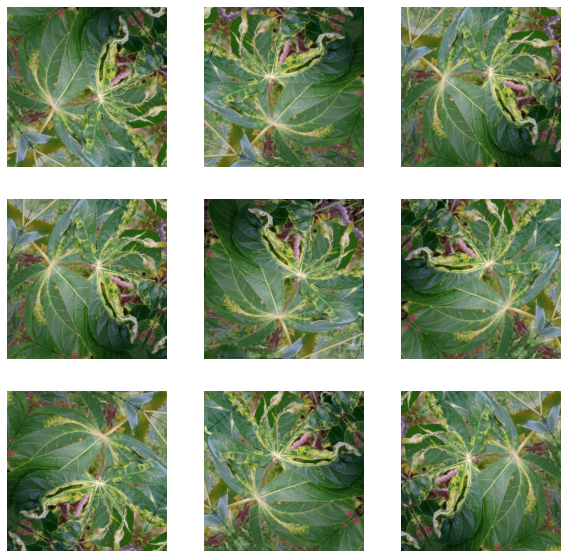

In [122]:
plt.figure(figsize=(10,10))
for i in range(9):
  augmented = data_augmentation(im_array)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented[0])
  plt.axis("off")

# Next 1% Improvement

1. Find out the intuition and the difference between `item_tfm` and `batch_tfm`
2. Customize my own data generator as fastai creates their `Dataloader`
3. Fix the TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment error and figure why there is a difference between Kaggle and Colab.

In [ ]:
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import math

# Here, `x_set` is list of path to the images
# and `y_set` are the associated classes.

class CIFAR10Sequence(Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]

        return np.array([
            resize(imread(file_name), (200, 200))
               for file_name in batch_x]), np.array(batch_y)

In [105]:
class CassavaGenerator(tf.keras.utils.Sequence):
  def __init__(self, path, data, bs, dim, shuffle=True, tfm=None,
               use_mixup=False, use_cutmix=False, use_fmix=False):
    self.path = path
    self.data = data
    self.bs = bs
    self.dim = dim
    self.shuffle = shuffle
    self.augment = tfm
    self.use_mixup = use_mixup
    self.use_cutmix = use_cutmix
    self.use_fmix = use_fmix
    self.list_ids = self.data.index.values
    self.label = pd.get_dummies(self.data['label'], columns=['label'])
    self.on_epoch_end()

  def __len__(self):
    return int(np.ceil(float(len(self.data)) / float(self.bs)))

  def __getitem__(self, index):
    start = index * self.bs
    end = (index+1) * self.bs
    batch_ids = self.indices[start:end]

    xs = np.empty((self.bs, *self.dim))
    ys = np.empty((self.bs, 5), dtype=np.float32)

    for i,k in enumerate(batch_ids):
      pdb.set_trace()
      imamge = tf.keras.preprocessing.image.load_img(
          train_df[train_df.label==3]['path'][0],
          grayscale = False,
          color_mode = 'rgb',
          target_size = None,
          interpolation = "nearest"
      )

      augmented = self.augment(image=image)
      image = augmented['image']

      xs[i, :, :, :] = image
      ys[i, :] = self.label.loc[k, :].values

      if self.use_cutmix:
        xs, ys = CutMix(xs, ys, self.dim[0])
        
      if self.use_mixup:
        xs, ys = MixUp(xs, ys, self.dim[0])

      if self.use_fmix:
        xs,  ys = FMix(xs, ys, self.dim[0])
    
    return xs, ys

  def on_epoch_end(self):
    self.indices = np.arange(len(self.list_ids))
    if self.shuffle: np.random.shuffle(self.indices)

In [ ]:
dg = CassavaGenerator(BaseConfig.TRAIN_IMG_PATH, df, 20, (128,128,3), shuffle=True,
                 use_mixup=False, use_cutmix=True, use_fmix=False,
                 tfm=albu_transforms_train(128))

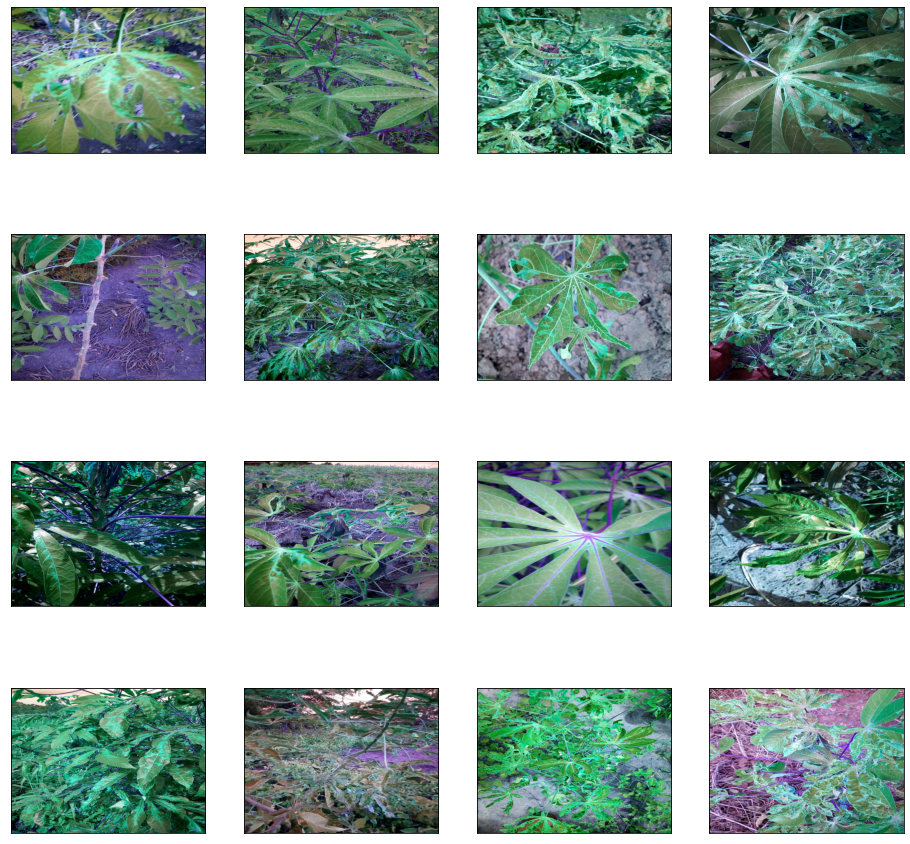

In [89]:
visualize(BaseConfig.TRAIN_IMG_PATH, 16, is_random=True)

# Augmentation

The `albumentation` is primarily used for resizing and normalization.

In [90]:
# For Training 
def albu_transforms_train(data_resize): 
    return A.Compose([
            A.ToFloat(),
            A.Resize(data_resize, data_resize),
        ], p=1.)

# For Validation 
def albu_transforms_valid(data_resize): 
    return A.Compose([
            A.ToFloat(),
            A.Resize(data_resize, data_resize),
        ], p=1.)

In [91]:
def CutMix(image, label, DIM, PROBABILITY = 1.0):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with cutmix applied
    CLASSES = 5
    
    imgs = []; labs = []
    for j in range(len(image)):
        # DO CUTMIX WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.int32)
        
        # CHOOSE RANDOM IMAGE TO CUTMIX WITH
        k = tf.cast( tf.random.uniform([],0,len(image)),tf.int32)
        
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        
        b = tf.random.uniform([],0,1) # this is beta dist with alpha=1.0
        
        WIDTH = tf.cast( DIM * tf.math.sqrt(1-b),tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)

        # MAKE CUTMIX IMAGE
        one = image[j,ya:yb,0:xa,:]
        two = image[k,ya:yb,xa:xb,:]
        three = image[j,ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        img = tf.concat([image[j,0:ya,:,:],middle,image[j,yb:DIM,:,:]],axis=0)
        imgs.append(img)
        
        # MAKE CUTMIX LABEL
        a = tf.cast(WIDTH*WIDTH/DIM/DIM,tf.float32)
        labs.append((1-a)*label[j] + a*label[k])
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image2 = tf.reshape(tf.stack(imgs),(len(image),DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(len(image),CLASSES))
    
    return image2,label2

In [92]:
def MixUp(image, label, DIM, PROBABILITY = 1.0):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with mixup applied
    CLASSES = 5
    
    imgs = []; labs = []
    for j in range(len(image)):
        # DO MIXUP WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.float32)
                   
        # CHOOSE RANDOM
        k = tf.cast( tf.random.uniform([],0,len(image)),tf.int32)
        a = tf.random.uniform([],0,1)*P # this is beta dist with alpha=1.0
                    
        # MAKE MIXUP IMAGE
        img1 = image[j,]
        img2 = image[k,]
        imgs.append((1-a)*img1 + a*img2)
                    
        # MAKE CUTMIX LABEL
        labs.append((1-a)*label[j] + a*label[k])
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image2 = tf.reshape(tf.stack(imgs),(len(image),DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(len(image),CLASSES))
    return image2,label2

# Custom Data Generator

In [107]:
def plot_imgs(dataset_show, iters):
    rcParams['figure.figsize'] = 20,10
    for i in range(iters):
        f, ax = plt.subplots(1,5)
        for p in range(5):
            idx = np.random.randint(0, len(dataset_show))
            img, label = dataset_show[idx]
            ax[p].grid(False)
            ax[p].imshow(img[0])
            ax[p].set_title(idx)
    plt.show()


In [108]:
dg = CassavaGenerator(BaseConfig.TRAIN_IMG_PATH, df, 20, (128,128,3), shuffle=True,
                 use_mixup=False, use_cutmix=True, use_fmix=False,
                 tfm=albu_transforms_train(128))

In [110]:
dg[0]

> <ipython-input-105-ccce2c0ab35a>(30)__getitem__()
-> image = cv2.imread(f"{self.path}/{self.data['image_id'][k]}")
(Pdb) n
> <ipython-input-105-ccce2c0ab35a>(31)__getitem__()
-> image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
(Pdb) n
> <ipython-input-105-ccce2c0ab35a>(33)__getitem__()
-> augmented = self.augment(image=image)
(Pdb) n
> <ipython-input-105-ccce2c0ab35a>(34)__getitem__()
-> image = augmented['image']
(Pdb) xs
array([[[[ 5.01746356e-001,  5.53707123e-001,  5.50765991e-001],
         [ 5.09558856e-001,  5.87990165e-001,  6.24509871e-001],
         [ 5.41038632e-001,  5.84175885e-001,  6.06571734e-001],
         ...,
         [ 2.22824752e-001,  2.99019605e-001,  3.82812507e-002],
         [ 2.46476710e-001,  3.19148272e-001,  1.17953438e-002],
         [ 2.37362146e-001,  2.87117034e-001,  1.76011026e-002]],

        [[ 5.01225531e-001,  5.45511723e-001,  5.32123208e-001],
         [ 5.21721840e-001,  5.91789246e-001,  6.02328479e-001],
         [ 5.21093786e-001,  5.990196

BdbQuit: ignored

# Moving to the next 1% improvement

1. Fix the `TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment` error and figure why there is a difference between Kaggle and Colab.